In [67]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import json
from scipy.stats import pearsonr
import SimpleITK as sitk


In [68]:
with open(r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Tables\tree.json") as f:
    tree = json.load(f)
    
def ct_ccf_sort(ctlist):
    ctlist = [x.replace("23","2/3") for x in ctlist]
    select_ct_sorted = []
    for item in tree:
        if item["acronym"] in ctlist:
            select_ct_sorted.append(item["acronym"])
    return select_ct_sorted

In [69]:
used_cols = ["Center Shift","Relative Center Shift",
         "Average Contraction",  "Average Bifurcation Angle Remote","Average Bifurcation Angle Local",
         "Max Branch Order","Number of Bifurcations","Total Length",
         "Max Euclidean Distance","Max Path Distance","Average Euclidean Distance","25% Euclidean Distance",
         "50% Euclidean Distance","75% Euclidean Distance", "Average Path Distance","25% Path Distance","50% Path Distance","75% Path Distance",       
         '2D Density', '3D Density',
         'Area', 'Volume', 'Width',  'Width_95','Height', 'Height_95', 'Depth', 'Depth_95', 
         'Slimness', 'Slimness_95', 'Flatness', 'Flatness_95']

material_path = r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Materials"
df_ct = pd.concat([pd.read_csv(os.path.join(material_path,"cell_type/s_type","AIBS+SEU-ALLEN_Full_1741.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","MouseLight_Full_1200.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","ION_Axon_6357.csv"), index_col=0)
                  ])
df_ct.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_ct.index]


df_axon = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Axon_Morphological_Features.csv'),index_col=0)
df_axon.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_axon.index]

df_axon = df_axon[used_cols]

df_den = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Dendrite_Morphological_Features.csv'),index_col=0)
df_den = df_den[~df_den.index.str.contains('^Img')]
df_den.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_den.index]

df_den.dropna(inplace=True)
df_den = df_den[used_cols]

# soma position
df_subtype = pd.read_csv(os.path.join(material_path, 'cell_type/c_type','ctype_unmirrored.csv'),index_col=0)
anno = sitk.GetArrayFromImage(sitk.ReadImage(
    r"E:\ZhixiYun\Projects\GitHub\vaa3d_tools\hackathon\mBrainAligner\src\src_othertools\process\annotation_25.nrrd"))


sl_1741 = pd.read_csv(os.path.join(material_path, 'soma_location', '1741_Soma_Location.csv'),index_col=0)
sl_1002 = pd.read_csv(os.path.join(material_path, 'soma_location', 'MouseLight_Soma_Location.csv'),index_col=0).iloc[:]
sl_ION = pd.read_csv(os.path.join(material_path, 'soma_location', 'ION_Soma_Location.csv'),index_col=0)
df_sl = pd.concat([sl_1741, sl_1002, sl_ION])
df_sl.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_sl.index]
df_sl.dropna(inplace=True)

df_sl

,x,y,z
17109_1701_x8048_y22277.swc,108.920000,148.804000,151.962000
17109_1801_x6698_y12550.swc,113.636000,136.714000,154.727000
17109_1901_x9602_y10508.swc,123.004000,183.974000,122.068000
17109_2201_x8046_y23301.swc,129.235000,142.621000,135.341000
17109_2301_x8535_y23051.swc,133.308000,151.149000,137.958000
...,...,...,...
201787_044_reg.swc,120.318486,128.302793,219.684775
201787_045_reg.swc,118.910440,116.284689,217.566681
201787_048_reg.swc,121.453392,113.448196,217.670578
201787_050_reg.swc,135.528418,125.900020,213.173718


In [70]:
tmpdf = df_subtype['detail ctype'].value_counts()
ctlist = np.unique([x.split('_')[0] for x in tmpdf[tmpdf>=2].index])
ctlist = ct_ccf_sort(ctlist)
subtlist = []
indice = []
for i,ct in enumerate(ctlist):
    tmpdf = df_subtype[df_subtype['detail ctype'].str.contains('^'+ct+'_')]['detail ctype']
    # if len(tmpdf)<2: continue
    tmpseries = tmpdf.value_counts()
    tmplist = list(np.unique(tmpseries[tmpseries>=10].index))
    if len(tmplist)<2: continue
    subtlist.append(tmplist)
    indice.append(i)
ctlist = np.array(ctlist)[np.array(indice)].tolist()
print(ctlist)
print(subtlist)

['FRP5', 'MOs2/3', 'MOs5', 'MOs6a', 'SSp5', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAv2/3', 'ACAv5', 'PL2/3', 'PL5', 'PL6a', 'ILA5', 'ORBl2/3', 'ORBl5', 'ORBm2/3', 'ORBm5', 'ORBvl1', 'ORBvl2/3', 'ORBvl5', 'ORBvl6a', 'AId2/3', 'AId5', 'AIv2/3', 'AIv5', 'SUB', 'CP', 'VPL', 'VPM', 'LGd']
[['FRP5_4', 'FRP5_5', 'FRP5_6'], ['MOs2/3_1', 'MOs2/3_2', 'MOs2/3_3'], ['MOs5_1', 'MOs5_2', 'MOs5_3'], ['MOs6a_1', 'MOs6a_2', 'MOs6a_3', 'MOs6a_4', 'MOs6a_5'], ['SSp5_1', 'SSp5_2', 'SSp5_3', 'SSp5_5'], ['ACAd2/3_1', 'ACAd2/3_2', 'ACAd2/3_3'], ['ACAd5_1', 'ACAd5_2', 'ACAd5_3'], ['ACAd6a_1', 'ACAd6a_2', 'ACAd6a_3'], ['ACAv2/3_1', 'ACAv2/3_2', 'ACAv2/3_3', 'ACAv2/3_4'], ['ACAv5_1', 'ACAv5_2', 'ACAv5_3', 'ACAv5_4'], ['PL2/3_1', 'PL2/3_2', 'PL2/3_3'], ['PL5_1', 'PL5_2', 'PL5_3'], ['PL6a_1', 'PL6a_3', 'PL6a_4'], ['ILA5_1', 'ILA5_2', 'ILA5_3'], ['ORBl2/3_1', 'ORBl2/3_2', 'ORBl2/3_3'], ['ORBl5_1', 'ORBl5_2', 'ORBl5_3', 'ORBl5_4'], ['ORBm2/3_1', 'ORBm2/3_3'], ['ORBm5_1', 'ORBm5_2', 'ORBm5_3', 'ORBm5_4', 'ORBm5_5'], ['ORB

MOs5_3    190
MOs5_2    143
MOs5_1    128
Name: subtype, dtype: int64


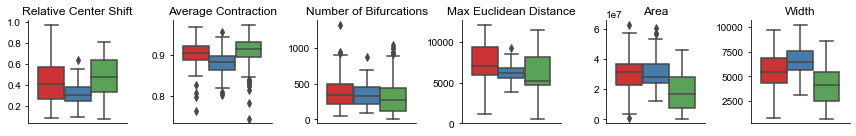

In [51]:
ct = 'MOs5'

tmpdf1 = df_axon.loc[df_subtype[df_subtype['detail ctype'].str.contains('^'+ct+'_')].index]
tmpdf1['subtype'] = df_subtype.loc[tmpdf1.index]['detail ctype']
print(tmpdf1.subtype.value_counts())

tmparr = tmpdf1.values[:,:-1].copy()
tmpdf1_seq = pd.DataFrame(tmparr.reshape(-1).T.astype(np.float32),columns=['value'])
tmpdf1_seq['feature'] = list(tmpdf1.columns[:-1])*len(tmpdf1)
tmpdf1_seq['c-type'] = np.array([tmpdf1.values[:,-1].reshape(-1).tolist()]*32).T.reshape(-1)

selected_features = ["Relative Center Shift",
         "Average Contraction", 
         "Number of Bifurcations",
         "Max Euclidean Distance", 
         'Area', 'Width']
tmpdf1_seq = tmpdf1_seq[tmpdf1_seq['feature'].isin(selected_features)]
tmpdf1_seq = tmpdf1_seq.reset_index(drop=True)

fig,axs=plt.subplots(1,len(selected_features),figsize=(12,2))
for i in range(len(selected_features)):
    fn = selected_features[i]
    ax=axs[i]
    g=sns.boxplot(data=tmpdf1_seq[tmpdf1_seq['feature']==fn],x='feature',y='value',hue='c-type',palette='Set1',hue_order=('MOs5_1','MOs5_2','MOs5_3'),ax=axs[i])
    ax.legend_.set_visible(False)
    ax.set_title(fn)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.tight_layout()
# fig.suptitle('axon feature',y=1.05)
plt.savefig(r'./fig6\MOs5_ctype_axon_feature_boxplot.svg',dpi=300,
                                           bbox_inches='tight',facecolor="white")
plt.show()

In [55]:
common_neuron = np.intersect1d(df_subtype.index, df_den.index)

tmpdf = df_subtype.loc[common_neuron]['detail ctype'].value_counts()
ctlist = np.unique([x.split('_')[0] for x in tmpdf[tmpdf>=2].index])
ctlist = ct_ccf_sort(ctlist)
subtlist = []
indice = []
for i,ct in enumerate(ctlist):
    tmpdf = df_subtype.loc[common_neuron][df_subtype.loc[common_neuron]['detail ctype'].str.contains('^'+ct+'_')]['detail ctype']
    # if len(tmpdf)<2: continue
    tmpseries = tmpdf.value_counts()
    tmplist = list(np.unique(tmpseries[tmpseries>=0].index))
    if len(tmplist)<2: continue
    # print(tmpseries)
    subtlist.append(tmplist)
    indice.append(i)
ctlist = np.array(ctlist)[np.array(indice)].tolist()
print(ctlist)
print(subtlist)

['MOs2/3', 'MOs5', 'MOs6a', 'SSp5', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAv2/3', 'ACAv5', 'ORBl5', 'ORBvl6a', 'SUB', 'CP', 'VPL', 'VPM', 'LGd']
[['MOs2/3_1', 'MOs2/3_2', 'MOs2/3_3'], ['MOs5_1', 'MOs5_2', 'MOs5_3'], ['MOs6a_1', 'MOs6a_2', 'MOs6a_3', 'MOs6a_4', 'MOs6a_5'], ['SSp5_1', 'SSp5_2', 'SSp5_3', 'SSp5_4', 'SSp5_5'], ['ACAd2/3_1', 'ACAd2/3_2', 'ACAd2/3_3'], ['ACAd5_1', 'ACAd5_2', 'ACAd5_3'], ['ACAd6a_1', 'ACAd6a_2', 'ACAd6a_3'], ['ACAv2/3_1', 'ACAv2/3_3'], ['ACAv5_1', 'ACAv5_4'], ['ORBl5_2', 'ORBl5_4'], ['ORBvl6a_1', 'ORBvl6a_2'], ['SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7'], ['CP_1', 'CP_2', 'CP_3'], ['VPL_1', 'VPL_2', 'VPL_3', 'VPL_4', 'VPL_5'], ['VPM_1', 'VPM_2', 'VPM_3'], ['LGd_1', 'LGd_2', 'LGd_3', 'LGd_4', 'LGd_5', 'LGd_6']]


MOs5_3    69
MOs5_2    58
MOs5_1    35
Name: subtype, dtype: int64


D:\anaconda3\envs\yzx\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


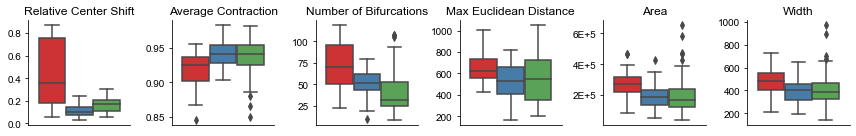

In [56]:
ct = 'MOs5'

tmpdf1 = df_den.loc[np.intersect1d(common_neuron, df_subtype.index[df_subtype['detail ctype'].str.contains('^'+ct+'_')])]
tmpdf1['subtype'] = df_subtype.loc[tmpdf1.index]['detail ctype']
print(tmpdf1.subtype.value_counts())

tmparr = tmpdf1.values[:,:-1].copy()
tmpdf1_seq = pd.DataFrame(tmparr.reshape(-1).T.astype(np.float32),columns=['value'])
tmpdf1_seq['feature'] = list(tmpdf1.columns[:-1])*len(tmpdf1)
tmpdf1_seq['c-type'] = np.array([tmpdf1.values[:,-1].reshape(-1).tolist()]*32).T.reshape(-1)

fig,axs=plt.subplots(1,len(selected_features),figsize=(12,2))
for i in range(len(selected_features)):
    fn = selected_features[i]
    ax=axs[i]
    if fn=='Number of Bifurcations':
        g=sns.boxplot(data=tmpdf1_seq[(tmpdf1_seq['feature']==fn)&(tmpdf1_seq['value']<=200)],x='feature',y='value',hue='c-type',palette='Set1',hue_order=('MOs5_1','MOs5_2','MOs5_3'),ax=axs[i])
    else:
        g=sns.boxplot(data=tmpdf1_seq[(tmpdf1_seq['feature']==fn)],x='feature',y='value',hue='c-type',palette='Set1',hue_order=('MOs5_1','MOs5_2','MOs5_3'),ax=axs[i])
    ax.legend_.set_visible(False)
    ax.set_title(fn)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if fn == 'Area':
        ax.set_yticklabels(['0','2E+5','4E+5','6E+5'])
    
fig.tight_layout()
# fig.suptitle('dendrite feature',y=1.05)
plt.savefig(r'.\fig6\MOs5_ctype_den_feature_boxplot.svg',dpi=300,
                                           bbox_inches='tight',facecolor="white")
plt.show()

In [72]:
overlap_swcname = np.intersect1d(df_den.index,df_axon.index)
overlap_swcname = np.intersect1d(overlap_swcname,df_subtype.index)
df_den = df_den.loc[overlap_swcname]
df_axon = df_axon.loc[overlap_swcname]
df_subtype = df_subtype.loc[overlap_swcname]
print(len(overlap_swcname))

1480


In [73]:
# ctlist = ['MOs5','LGd','VPM']
tmpdf = df_subtype['detail ctype'].value_counts()
ctlist = np.unique([x.split('_')[0] for x in tmpdf[tmpdf>=2].index])
ctlist = ct_ccf_sort(ctlist)
subtlist = []
indice = []
for i,ct in enumerate(ctlist):
    tmpdf = df_subtype[df_subtype['detail ctype'].str.contains('^'+ct+'_')]['detail ctype']
    # if len(tmpdf)<2: continue
    tmpseries = tmpdf.value_counts()
    tmplist = list(np.unique(tmpseries[tmpseries>=20].index))
    if len(tmplist)<2: continue
    subtlist.append(tmplist)
    indice.append(i)
ctlist = np.array(ctlist)[np.array(indice)].tolist()
print(ctlist)
print(subtlist)

from scipy.stats import pearsonr
ct_corr = []
for ct in ctlist:
    corr = []
    pv = []
    for i in range(len(used_cols)):
        corr_cur=[]
        pv_cur=[]
        for j in range(len(used_cols)):
            tup = pearsonr(df_den[df_subtype['detail ctype'].str.contains('^'+ct+'_')][used_cols[i]], df_axon[df_subtype['detail ctype'].str.contains('^'+ct+'_')][used_cols[j]])
            corr_cur.append(round(tup[0],6))
            pv_cur.append(tup[1])
        corr.append(corr_cur)
        pv.append(pv_cur)
    ct_corr.append(corr)
    
subt_corr = []
for subl in subtlist:
    sub_corr = []
    for ct in subl:
        corr = []
        pv = []
        for i in range(len(used_cols)):
            corr_cur=[]
            pv_cur=[]
            for j in range(len(used_cols)):
                tup = pearsonr(df_den[df_subtype['detail ctype']==ct][used_cols[i]], df_axon[df_subtype['detail ctype']==ct][used_cols[j]])
                corr_cur.append(round(tup[0],6))
                pv_cur.append(tup[1])
            corr.append(corr_cur)
            pv.append(pv_cur)
        sub_corr.append(corr)
    subt_corr.append(sub_corr)

['MOs2/3', 'MOs5', 'SSp5', 'CP', 'VPL', 'VPM']
[['MOs2/3_1', 'MOs2/3_2'], ['MOs5_1', 'MOs5_2', 'MOs5_3'], ['SSp5_1', 'SSp5_2', 'SSp5_3', 'SSp5_5'], ['CP_1', 'CP_2', 'CP_3'], ['VPL_1', 'VPL_3', 'VPL_5'], ['VPM_1', 'VPM_2', 'VPM_3']]


In [74]:
values=[]
names=[]
ctnums = []
for i in range(len(ctlist)):
    ct,ctcorr = ctlist[i], ct_corr[i]
    subl,subc = subtlist[i],subt_corr[i]
    names.append(ct)
    ctnums.append(np.sum(df_subtype['detail ctype'].str.contains('^'+ct+'_')))
    values.append([ctcorr[m][m] for m in range(len(ctcorr))])
    for j in range(len(subl)):
        subct,subcorr = subl[j],subc[j]
        names.append(subct)
        ctnums.append(np.sum(df_subtype['detail ctype']==subct))
        values.append([subcorr[m][m] for m in range(len(subcorr))])
df_den_axon_corr = pd.DataFrame(values,index=[names[x]+" ({})".format(ctnums[x]) for x in range(len(names))],columns=used_cols)


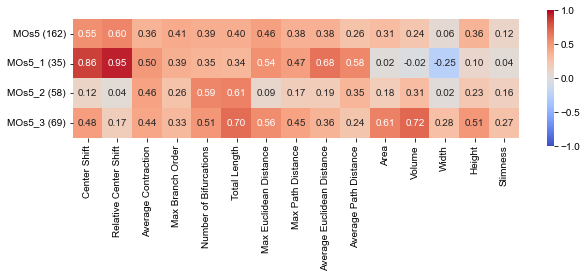

In [75]:
selected_features = ["Center Shift","Relative Center Shift",
         "Average Contraction", 
         "Max Branch Order","Number of Bifurcations","Total Length",
         "Max Euclidean Distance","Max Path Distance","Average Euclidean Distance", "Average Path Distance",     
         'Area', 'Volume', 'Width',  'Height', 
         'Slimness']

df_den_axon_corr.loc[df_den_axon_corr.index[3:7],selected_features].to_csv(r'./fig6/corr_heatmap.csv')

import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df_den_axon_corr.loc[df_den_axon_corr.index[3:7],selected_features],square=True,vmin=-1,vmax=1, cbar_kws={'shrink':0.25,'orientation':'vertical'},
            annot=True,cmap='coolwarm',fmt='.2f',annot_kws={'weight':540,'fontname':'arial','fontsize':10})
plt.xticks(fontsize=10,weight=540)
plt.yticks(fontsize=10,weight=540)
plt.savefig(r'./fig6\MOs5_axon_den_corr.svg',dpi=300,
                                           bbox_inches='tight',facecolor="white")
plt.show()

In [96]:
import glob

df_overlap = pd.DataFrame()
for fn in ['MOs_connectivity_dend_domains.csv', 'FRP_connectivity_dend_domains.csv']:
    fp = os.path.join(material_path, 'connectivity_matrix/coarse', fn)
    tmpdf = pd.read_csv(fp,index_col=0)
    df_overlap = pd.concat([df_overlap,tmpdf],ignore_index=False)

# for tmpcsv in os.listdir(r'E:\ZhixiYun\Projects\Neuron_Morphology_Table\linus\stypes\csv\rough'):
#     tmpdf = pd.read_csv(rf'E:\ZhixiYun\Projects\Neuron_Morphology_Table\linus\stypes\csv\rough\{tmpcsv}',index_col=0)
#     df_overlap = pd.concat([df_overlap,tmpdf],ignore_index=False)
    
df_overlap = df_overlap[~df_overlap.index.duplicated('last')]
df_overlap = df_overlap.dropna(how='all',axis=1)
df_overlap = df_overlap.fillna(0)
df_overlap = (df_overlap+1).apply(np.log2)
print(df_overlap.shape)


(1145, 65)


In [97]:
import umap
from scipy.spatial.distance import cdist

def generate_similarity_matrix(arr, metric='cosine'):
    sim_mat = np.zeros((len(arr),len(arr)),dtype=np.float32)
    cdist_result = cdist(arr,arr,metric=metric)
    if metric == 'cosine':
        sim_mat = 1-cdist_result
    if metric == 'euclidean':
        sim_mat = np.exp(-cdist_result)
    return sim_mat

In [98]:
df_axon = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Axon_Morphological_Features.csv'),index_col=0)
df_axon.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_axon.index]

df_axon = df_axon[used_cols]

df_den = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Dendrite_Morphological_Features.csv'),index_col=0)
df_den = df_den[~df_den.index.str.contains('^Img')]
df_den.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_den.index]

df_den.dropna(inplace=True)
df_den = df_den[used_cols]

# soma position
df_subtype = pd.read_csv(os.path.join(material_path, 'cell_type/c_type','ctype_unmirrored.csv'),index_col=0)

In [95]:
# tmpdf = df_ct[df_ct['CellType'].isin(['MOs','FRP'])]
tmpdf = df_ct[df_ct['Detail CellType'].isin(['MOs5','FRP5'])]
celllist = tmpdf.index

eps=1e-20

df_morpho = df_axon.loc[celllist]
morpho_stand_value = (df_morpho.values - df_morpho.values.mean(axis=0)) / (df_morpho.values.std(axis=0)+ eps)
morpho_sim_mat = generate_similarity_matrix(morpho_stand_value)
df_morpho_sim_mat = pd.DataFrame(morpho_sim_mat,index=df_morpho.index,columns=df_morpho.index)

df_conn = df_overlap.loc[celllist,df_overlap.columns[:-1]]
df_conn = df_conn.loc[:, df_conn.sum(axis=0)!=0]
conn_stand_value = (df_conn.values - df_conn.values.mean(axis=0)) / (df_conn.values.std(axis=0)+ eps)
conn_sim_mat = generate_similarity_matrix(conn_stand_value)
df_conn_sim_mat = pd.DataFrame(conn_sim_mat,index=df_conn.index,columns=df_conn.index)

df_somaloc = df_sl.loc[celllist]
dist_mat = cdist(df_somaloc.values,df_somaloc.values,metric='euclidean')
dist_mat = dist_mat/np.max(dist_mat)
dist_mat_exp = np.exp(-dist_mat**2)


aug_mat_morpho = morpho_sim_mat*dist_mat_exp
aug_mat_conn = conn_sim_mat*dist_mat_exp

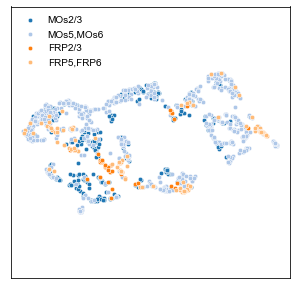

In [22]:
celltypelist = tmpdf.loc[celllist]['CellType'].values
detailctlist = tmpdf.loc[celllist]['Detail CellType'].values
# celltypelist = tmpdf['Detail CellType'].values

ump = umap.UMAP(random_state=520821)
ump_result = ump.fit_transform(aug_mat_conn)

fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1,aspect='equal',adjustable='datalim')
# plt.subplot(aspect='equal',adjustable='box')
# for i,dct in enumerate(['MOs5','FRP5']):
for i,dct in enumerate(['MOs2/3','MOs5,MOs6','FRP2/3','FRP5,FRP6']):
    if i==1:
        bool_list = np.isin(detailctlist,['MOs5','MOs6','MOs6a','MOs6b'])
    elif i==3:
        bool_list = np.isin(detailctlist,['FRP5','FRP6','FRP6a','FRP6b'])
    else:
        bool_list = detailctlist==dct
    plt.scatter(ump_result[bool_list][:,0],ump_result[bool_list][:,1],
                color=sns.color_palette('tab20',4)[i],label=dct,lw=0.5,s=20,edgecolor='white')
plt.legend(framealpha=0,loc=2)
plt.xticks([])
plt.yticks([])
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.title('Morphology')
# plt.title('Connectivity')
# plt.savefig(r'./fig6\MOs_FRP_UMAP_Connectivity.svg',dpi=300,
#               bbox_inches='tight',facecolor="white")
plt.show()


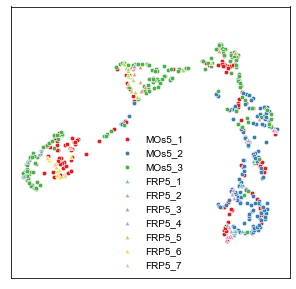

In [26]:
celltypelist = tmpdf['CellType'].values
detailctlist = tmpdf['Detail CellType'].values
tmpindice = []
tmpindice_index = []
for i,ind in enumerate(tmpdf.index):
    if ind in df_subtype.index:
        tmpindice.append(ind)
        tmpindice_index.append(i)
tmpindice_index = np.asarray(tmpindice_index)
subctlist = df_subtype.loc[tmpindice]['detail ctype'].values
# celltypelist = tmpdf['Detail CellType'].values

ump = umap.UMAP(random_state=520821,n_neighbors=15)
ump_result = ump.fit_transform(aug_mat_morpho[tmpindice_index])

fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1,aspect='equal',adjustable='datalim')
# plt.subplot(aspect='equal',adjustable='box')
# for i,dct in enumerate(['MOs5','FRP5']):
for i,dct in enumerate(['MOs5_1','MOs5_2','MOs5_3','FRP5_1','FRP5_2','FRP5_3','FRP5_4','FRP5_5','FRP5_6','FRP5_7']):
    bool_list = subctlist==dct
    if dct.startswith('MOs5'): marker='o'
    else: marker='^'
    plt.scatter(ump_result[bool_list][:,0],ump_result[bool_list][:,1],marker=marker,
                color=(sns.color_palette('Set1',3)+sns.color_palette('Set2',7))[i],label=dct,lw=0.5,s=20,edgecolor='white')
plt.legend(framealpha=0,loc='best')
plt.xticks([])
plt.yticks([])
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.title('Morphology')
# plt.title('Connectivity')
plt.savefig(r'./fig6\MOs5_FRP5_UMAP_Morphology_shape.svg',dpi=300,
              bbox_inches='tight',facecolor="white")
plt.show()
plt.close()

In [99]:
# tmpdf = df_ct[df_ct['CellType'].isin(['MOs','FRP'])]
tmpdf = df_ct[df_ct['Detail CellType'].isin(['MOs2/3','FRP2/3'])]
celllist = tmpdf.index
eps=1e-20

df_morpho = df_axon.loc[celllist]
morpho_stand_value = (df_morpho.values - df_morpho.values.mean(axis=0)) / (df_morpho.values.std(axis=0)+ eps)
morpho_sim_mat = generate_similarity_matrix(morpho_stand_value)
df_morpho_sim_mat = pd.DataFrame(morpho_sim_mat,index=df_morpho.index,columns=df_morpho.index)

df_conn = df_overlap.loc[celllist,df_overlap.columns[:-1]]
conn_stand_value = (df_conn.values - df_conn.values.mean(axis=0)) / (df_conn.values.std(axis=0)+ eps)
conn_sim_mat = generate_similarity_matrix(conn_stand_value)
df_conn_sim_mat = pd.DataFrame(conn_sim_mat,index=df_conn.index,columns=df_conn.index)

df_somaloc = df_sl.loc[celllist]
dist_mat = cdist(df_somaloc.values,df_somaloc.values,metric='euclidean')
dist_mat = dist_mat/np.max(dist_mat)
dist_mat_exp = np.exp(-dist_mat**2)


aug_mat_morpho = morpho_sim_mat*dist_mat_exp
aug_mat_conn = conn_sim_mat*dist_mat_exp

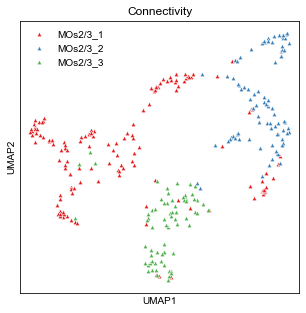

In [46]:
celltypelist = tmpdf['CellType'].values
detailctlist = tmpdf['Detail CellType'].values
tmpindice = []
tmpindice_index = []
for i,ind in enumerate(tmpdf.index):
    if ind in df_subtype.index:
        tmpindice.append(ind)
        tmpindice_index.append(i)
tmpindice_index = np.asarray(tmpindice_index)
subctlist = df_subtype.loc[tmpindice]['detail ctype'].values
# celltypelist = tmpdf['Detail CellType'].values

ump = umap.UMAP(random_state=520821,n_neighbors=15)
ump_result = ump.fit_transform(aug_mat_conn[tmpindice_index])

fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1,aspect='equal',adjustable='datalim')
# plt.subplot(aspect='equal',adjustable='box')
# for i,dct in enumerate(['MOs5','FRP5']):
for i,dct in enumerate(['MOs2/3_1','MOs2/3_2','MOs2/3_3']):
    bool_list = subctlist==dct
    if dct.startswith('MOs2/3'): marker='^'
    else: marker='s'
    plt.scatter(ump_result[bool_list][:,0],ump_result[bool_list][:,1],marker=marker,
                color=(sns.color_palette('Set1',3)+sns.color_palette('Set2',7))[i],label=dct,lw=0.5,s=20,edgecolor='white')
plt.legend(framealpha=0,loc='best')
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
# plt.title('Morphology')
plt.title('Connectivity')
# plt.savefig(r'./fig6\MOs2_3_UMAP_Connectivity_shape.svg',dpi=300,
#               bbox_inches='tight',facecolor="white")
plt.show()
plt.close()

In [100]:
def find_discontinuities(label_list):
    discontinuous_positions = []
    for i in range(len(label_list) - 1):  # Traverse the list
        if label_list[i + 1] - label_list[i] > 1:  # Check for discontinuity
            discontinuous_positions.append(i + 1)  # Store the position of the discontinuity
    return discontinuous_positions


from sklearn.cluster import spectral_clustering
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sknetwork.clustering import Louvain, PropagationClustering, modularity
from scipy import sparse

knn_num = 15


celltypelist = tmpdf['CellType'].values
detailctlist = tmpdf['Detail CellType'].values
tmpindice = []
tmpindice_index = []
for i,ind in enumerate(tmpdf.index):
    if ind in df_subtype.index:
        tmpindice.append(ind)
        tmpindice_index.append(i)
tmpindice_index = np.asarray(tmpindice_index)
subctlist = df_subtype.loc[tmpindice]['detail ctype'].values
# celltypelist = tmpdf['Detail CellType'].values

# data = aug_mat_conn[tmpindice_index].copy()
data = conn_stand_value.copy()
data_pca = PCA(0.99).fit_transform(data)
print(data.shape,data_pca.shape)
G = kneighbors_graph(data_pca,knn_num).toarray()
G = kneighbors_graph(G,knn_num,mode='distance',metric='jaccard').toarray()
G[G>0] = 1-G[G>0]
adjacency = sparse.csr_matrix(G)

scorelist_c = []
clunumlist_c = []
reslist = []
for res in range(-1000,1000,1):
    res = 1.01**res
    # compute the best partition
    louvain = Louvain(resolution=res, random_state=520821)
    louvain.fit(adjacency)
    labels=louvain.labels_
    # print(np.unique(labels).shape, res, end='\t')
    
    if len(set(labels))>10 or len(set(labels))==1: continue
    # score = silhouette_score(G, labels, metric='euclidean')
    score = modularity(G,labels)
    clunumlist_c.append(len(set(labels)))
    reslist.append(res)
    
    scorelist_c.append(score)

for i in find_discontinuities(clunumlist_c):
    for res in np.linspace(reslist[i-1],reslist[i],num=11,endpoint=False)[1:]:
        louvain = Louvain(resolution=res, random_state=520821)
        louvain.fit(adjacency)
        labels=louvain.labels_
        score = modularity(G,labels)
        clunumlist_c.append(len(set(labels)))
        reslist.append(res)

        scorelist_c.append(score)
    
# data = aug_mat_morpho[tmpindice_index].copy()
data = morpho_stand_value.copy()
data_pca = PCA(0.99).fit_transform(data)
print(data.shape,data_pca.shape)
G = kneighbors_graph(data_pca,knn_num).toarray()
G = kneighbors_graph(G,knn_num,mode='distance',metric='jaccard').toarray()
G[G>0] = 1-G[G>0]
adjacency = sparse.csr_matrix(G)

scorelist_m = []
clunumlist_m = []
for res in range(-1000,1000,1):
    res = 1.01**res
    # compute the best partition
    louvain = Louvain(resolution=res, random_state=520821)
    louvain.fit(adjacency)
    labels=louvain.labels_
    
    if len(set(labels))>10 or len(set(labels))==1: continue
    score = modularity(G,labels)
    clunumlist_m.append(len(set(labels)))
    scorelist_m.append(score)


(338, 64) (338, 54)


D:\anaconda3\envs\yzx\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


(338, 32) (338, 20)


D:\anaconda3\envs\yzx\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [101]:
'''switch MOs_FRP_L2_3 or MOs_FRP_L5'''
df_t_pca = pd.read_csv(os.path.join(material_path, 'gene_profile/MOs_FRP_L2_3','pca_feature.csv'),index_col=0)
df_t_label = pd.read_csv(os.path.join(material_path, 'gene_profile/MOs_FRP_L2_3','sele_labels.csv'),index_col=0)
print(df_t_pca.shape,df_t_label.shape)
G = kneighbors_graph(df_t_pca.values,knn_num).toarray()
G = kneighbors_graph(G,knn_num,mode='distance',metric='jaccard').toarray()
G[G>0] = 1-G[G>0]
adjacency = sparse.csr_matrix(G)

scorelist_t = []
clunumlist_t = []
for res in range(-1000,1000,1):
    res = 1.01**res
    # compute the best partition
    louvain = Louvain(resolution=res, random_state=520821)
    louvain.fit(adjacency)
    labels=louvain.labels_
    
    if len(set(labels))>10 or len(set(labels))==1: continue
    score = modularity(G,labels)
    clunumlist_t.append(len(set(labels)))
    scorelist_t.append(score)

(6129, 50) (6388, 5)


D:\anaconda3\envs\yzx\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


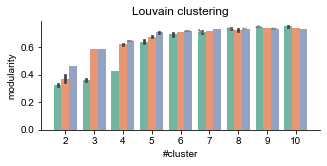

In [102]:
fig,ax=plt.subplots(1,1,figsize=(5,2))
sns.barplot(x=clunumlist_t+clunumlist_c+clunumlist_m,y=scorelist_t+scorelist_c+scorelist_m,ci='sd',
            hue=['transcriptomic feature']*len(scorelist_t)+['connectivity feature']*len(scorelist_c)+['morphological feature']*len(scorelist_m),ax=ax, palette='Set2')

df = pd.DataFrame(columns=['modularity','total_clusters','type'])
df['modularity'] = scorelist_t+scorelist_c+scorelist_m
df['total_clusters'] = clunumlist_t+clunumlist_c+clunumlist_m
df['type'] = ['transcriptomic']*len(scorelist_t) + ['connectivity']*len(scorelist_c) + ['morphology']*len(scorelist_m)
df.to_csv(r'./supp/modularity_MOs_FRP_L2_3.csv')

for i,[clunumlist,scorelist] in enumerate(zip([clunumlist_t,clunumlist_c,clunumlist_m],[scorelist_t,scorelist_c,scorelist_m])):
    _1,_2 = np.unique(clunumlist, return_counts=True)
    for clunum, counts in zip(_1,_2):
        if counts<=10:
            np.random.seed(520821)
            jitter = np.random.uniform(-0.1, 0.1, counts)
            ax.scatter(np.array([clunum-2+(i-1)*0.267] * counts) + jitter, np.array(scorelist)[np.array(clunumlist)==clunum], 
                       # color=np.array(sns.color_palette('Set2',3)[i])**1,
                       facecolors='none',
                       zorder=5,lw=0.5,edgecolor='gray',s=2,)

            
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Louvain clustering')
ax.set_xlabel('#cluster')
ax.set_ylabel('modularity')
# ax.legend(mode='expand',frameon=False)
ax.legend_.remove()
fig.savefig(r'./supp/val_MOs_FRP_L2_3_louvain.svg',dpi=400,
              bbox_inches='tight',facecolor="white")
plt.show(fig)

In [103]:
print('transcriptomic',np.unique(clunumlist_t, return_counts=True))
print('connectivity',np.unique(clunumlist_c, return_counts=True))
print('morphology',np.unique(clunumlist_m, return_counts=True))

transcriptomic (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), array([410,  29,  62,  69,  15,  10,   6,  10,  14], dtype=int64))
connectivity (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), array([36, 28, 51, 23, 15, 35, 29, 20, 34], dtype=int64))
morphology (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), array([113,  40,   7,  64,   6,  47,   3,   8,  60], dtype=int64))
